In [1]:
# Import libraries
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


# Import custom modules and packages
import params.inceptionv2_imagenet
import utils.log
import utils.train
import utils.test
import utils.validate
from inceptionv2 import GoogleNetBN

### Load the learning parameters

In [2]:
LEARNING_PARAMS = params.inceptionv2_imagenet.LEARNING

### Prepare the data

In [3]:
# Compose several transforms together to be applied to data
# (Note that transforms are not applied yet)
transform = transforms.Compose([
    # Modify the size of the images
    transforms.Resize(params.inceptionv2_imagenet.IMAGE_SHAPE),
    
    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(**params.inceptionv2_imagenet.NORMALIZE_PARAMS),
])

# Load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root = '.',
    train = True,
    transform = transform,
    download = True,
)

# Load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root = '.',
    train = False,
    transform = transform,
    download=True,
)


# As MNIST does not provide a validation dataset, we will split the train
# dataset into a train and a validation dataset

# Start by loading the train dataset, with the same transform as the
# test dataset
val_dataset = torchvision.datasets.MNIST(
    root = '.',
    train = True,
    transform = transform,
)

# Set the train dataset size as a percentage of the original train dataset
train_size = (len(train_dataset) - len(test_dataset))/len(train_dataset)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_dataset)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(val_dataset, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = LEARNING_PARAMS['batch_size'],
    shuffle = True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = LEARNING_PARAMS['batch_size'],
    shuffle = False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

In [4]:
# Get the number of samples per split
NB_TRAIN = len(train_dataset)
NB_VAL = len(val_dataset)
NB_TEST = len(test_dataset)

# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100, 1)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100, 1)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100, 1)} % of the data for testing ({NB_TEST} samples)")

71.4 % of the data for training (50000 samples)
14.3 % of the data for validation (10000 samples)
14.3 % of the data for testing (10000 samples)


### Device selection

In [5]:
# Use a GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



### Training and validation

In [6]:
# Instantiate a model
model = GoogleNetBN(nb_classes=params.inceptionv2_imagenet.NB_CLASSES).to(device=device)

# Define the loss function (combines nn.LogSoftmax() and nn.NLLLoss())
criterion = torch.nn.CrossEntropyLoss()

# Set the optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_PARAMS["learning_rate"],
    weight_decay=LEARNING_PARAMS["weight_decay"])

/home/tom/miniconda3/envs/mla/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
# Create tensors to store the loss and accuracy values
loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])
accuracy_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])


# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_loss, train_accuracy = utils.train.train(model,
                                                   device,
                                                   train_loader,
                                                   optimizer,
                                                   criterion,
                                                   epoch)
    
    # Validation
    val_loss, val_accuracy = utils.validate.validate(model,
                                                     device,
                                                     val_loader,
                                                     criterion,
                                                     epoch) 
    
    
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy


Epoch 0 [val]: 100%|██████████| 157/157 [00:01<00:00, 78.96batch/s, batch_loss=0.792]


Train accuracy:  92.118
Validation accuracy:  85.46


Epoch 1 [val]: 100%|██████████| 157/157 [00:02<00:00, 77.17batch/s, batch_loss=0.0587]


Train accuracy:  96.394
Validation accuracy:  97.97


Epoch 2 [val]: 100%|██████████| 157/157 [00:02<00:00, 70.96batch/s, batch_loss=0.0203]


Train accuracy:  97.22
Validation accuracy:  96.64


Epoch 3 [val]: 100%|██████████| 157/157 [00:02<00:00, 73.37batch/s, batch_loss=0.026]  

Train accuracy:  97.336
Validation accuracy:  98.49


#### Visualize the loss and accuracy

Text(0.5, 0, 'Epoch')

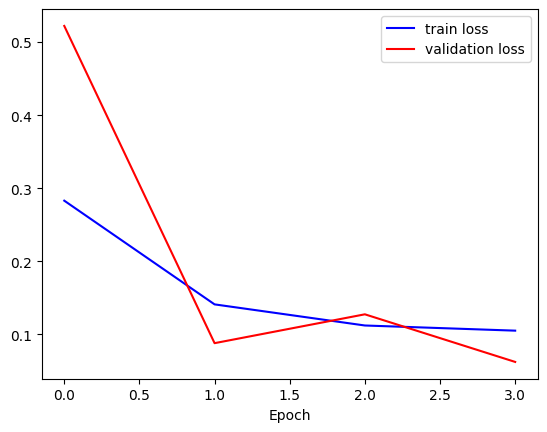

In [8]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

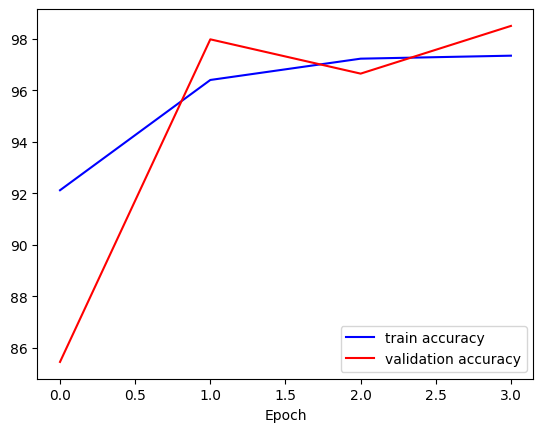

In [9]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

### Testing

In [10]:
# Test the model
test_loss, test_accuracy = utils.test.test(model,
                                           device,
                                           test_loader,
                                           criterion)

print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

Test loss:  0.06404546416471386
Test accuracy:  98.32


### Generate a log directory

In [11]:
# Turn interactive plotting off
plt.ioff()

# Get the learning parameters table
params_table = utils.log.parameters_table(
    dataset="MNIST",
    learning_params=LEARNING_PARAMS)

# Set the path to the results directory
results_directory = "logs/." +\
    datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
                        
# Generate the log directory
utils.log.generate_log(
    results_directory=results_directory,
    test_accuracy=test_accuracy,
    parameters_table=params_table,
    model=model,
    accuracy_values=accuracy_values)